In [19]:
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import imageio
import os

from kan import *

## Load training set

parameters shape: (13000, 3)
SQ shape: (13000, 95)
parameters mean: [ 0.2175  0.26   10.5   ]
parameters std: [0.1125     0.14422205 5.7662813 ]
Q shape: (95,)
Outliers are at indices: (array([9139, 9158, 9159, 9178, 9179, 9619, 9639, 9658, 9659, 9679]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))


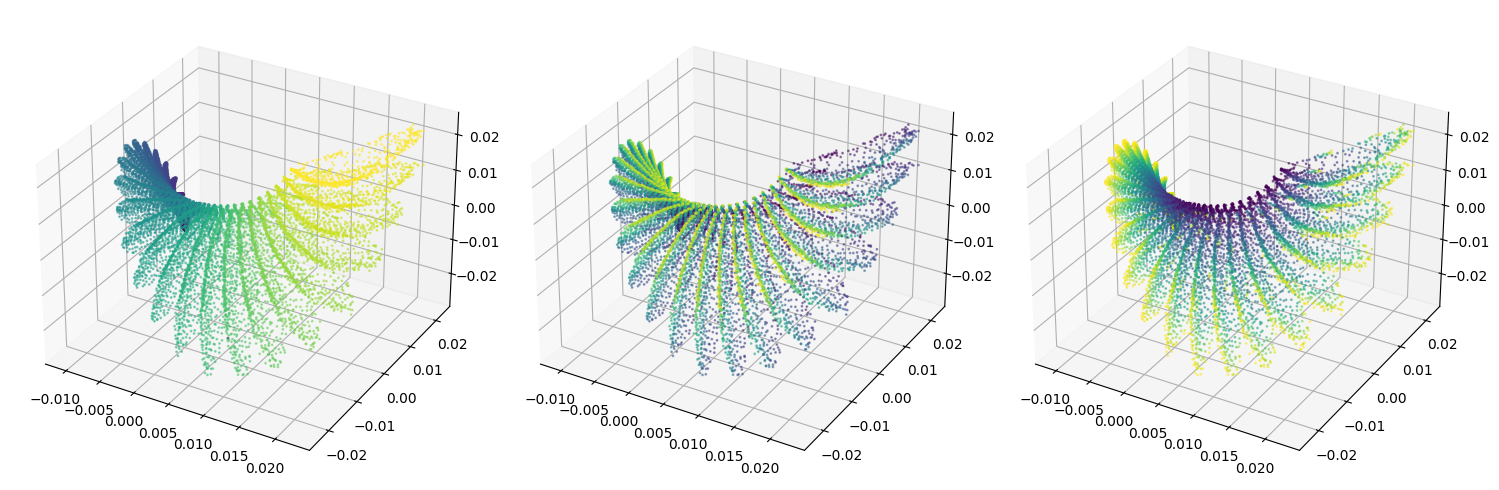

In [20]:
data_rand = loadmat("./training_sets/fg/SQ_rand_fg.mat")
data_grid = loadmat("./training_sets/fg/SQ_grid_fg.mat")
parameters_list = data_grid["parameters_list"]
SQ_list = data_grid["SQ_list"][:,5:]
parameters_list_rand = data_rand["parameters_list"]
SQ_list_rand = data_rand["SQ_list"][:,5:]

# SQ_list = np.loadtxt('./training_sets/input_grid_all_GPR80.csv',  delimiter=',')[:,:-1]
# parameters_list = np.loadtxt('./training_sets/target_grid_all.csv',  delimiter=',')[:,:-1]

# exclude highest interaction
index_parameters = (parameters_list[:,2]<=20)*(parameters_list[:,0]<=0.405)*(parameters_list[:,0]>=0.03)
parameters_list = parameters_list[index_parameters,:]
SQ_list = SQ_list[index_parameters,:]

# index_parameters_rand = (parameters_list_rand[:,2]<=20)*(parameters_list_rand[:,0]<=0.405)
# parameters_list_rand = parameters_list_rand[index_parameters_rand,:]
# SQ_list_rand = SQ_list_rand[index_parameters_rand,:]

print(f"parameters shape: {parameters_list.shape}")
print(f"SQ shape: {SQ_list.shape}")

# rescale the training set SQ to range [0,1]
exp_scale = 2
def f_inp(sq):
    return np.log(sq)/exp_scale/2

# transform the decoder output to SQ
def f_out(sq_pred):
    return np.exp((sq_pred*2)*exp_scale) # inverse of f_inp

def f_out_torch(sq_pred):
    return torch.exp((sq_pred*2)*exp_scale) # inverse of f_inp

parameters_mean = np.mean(parameters_list, axis=0)
parameters_std = np.std(parameters_list, axis=0)
print(f"parameters mean: {parameters_mean}")
print(f"parameters std: {parameters_std}")

# y_train = f_inp(SQ_list)
y_train = SQ_list
# x_train = np.array([(parameters_list[:,i]-np.mean(parameters_list[:,i]))/np.std(parameters_list[:,i]) for i in range(3)]).T
x_train = np.array([(parameters_list[:,i]) for i in range(3)]).T

y_train_ext = SQ_list_rand
# x_train_ext = np.array([(parameters_list_rand[:,i]-np.mean(parameters_list[:,i]))/np.std(parameters_list[:,i]) for i in range(3)]).T
x_train_ext = np.array([(parameters_list_rand[:,i]) for i in range(3)]).T


# # extend training set
# y_train = np.vstack((y_train,y_train_ext))
# x_train = np.vstack((x_train,x_train_ext))

def f_params_z(parameters):
    return np.array([(parameters[i]-parameters_mean[i])/parameters_std[i] for i in range(3)])

Q = np.linspace(1.2,20,95)
print(f"Q shape: {Q.shape}")

# Identify outliers
from scipy import stats

# Perform SVD
y_train_centered = y_train - np.mean(y_train, axis=0)
U, S, Vt = np.linalg.svd(y_train_centered, full_matrices=False)

# Get the first 3 principal components
PC = U[:, :3]

# Compute the Z-scores of the principal components
z_scores = np.abs(stats.zscore(PC))

outliers = np.where(z_scores > 3)  # change 3 to a different value if you want to use a different threshold

# Print the indices of the outliers
print("Outliers are at indices:", outliers)

# Remove outliers
y_train = np.delete(y_train, outliers, axis=0)
x_train = np.delete(x_train, outliers, axis=0)

# Perform SVD
y_train_ave = np.mean(y_train, axis=0)
y_train_centered = y_train - y_train_ave
U, S, Vt = np.linalg.svd(y_train_centered, full_matrices=False)

# Get the first 3 principal components
PC = U[:, :3]

# Create a 3D plot
fig = plt.figure(figsize=(15, 5))
colormap = plt.cm.get_cmap('viridis')  # or any other colormap you like

for i in range(3):
    # Create a colormap based on x_train
    colors = colormap((x_train[:,i]-np.min(x_train[:,i]))/(np.max(x_train[:,i])-np.min(x_train[:,i])))

    ax = fig.add_subplot(1,3,i+1, projection='3d')
    ax.scatter(PC[:, 0], PC[:, 1], PC[:, 2], c=colors, s=1, alpha=0.5)

plt.tight_layout()
plt.show()

In [21]:
# y_train = np.log(y_train)

# Add a column of ones to x to account for the bias term
x_train_bias = np.hstack([x_train, np.ones((x_train.shape[0], 1))])

# Initialize A and B
A = np.zeros((x_train.shape[1], y_train.shape[1]))
B = np.zeros(y_train.shape[1])

# For each target variable
for i in range(y_train.shape[1]):
    # Solve for A and B using least squares
    coef, _, _, _ = np.linalg.lstsq(x_train_bias, y_train[:, i], rcond=None)
    A[:, i] = coef[:-1]
    B[i] = coef[-1]

## Define model

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# cpu = torch.device('cpu')
# device = cpu
torch.set_default_dtype(torch.float32)

cuda


In [23]:
def calculate_output_size(input_size, filter_size, padding, stride):
    return int((input_size - filter_size + 2*padding) / stride + 1)

def to_torch(array):
    return torch.from_numpy(array).float()

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
def to_torch_device(array,device=device):
    return torch.from_numpy(array.astype('float32')).float().to(device)

In [24]:
## define KAN model
Q = np.linspace(1.2,20,95)
class SQ_KAN(nn.Module):
    def __init__(self, width=[4,11,1], width_aug=[3,7,7,3], grid=9, k=3, seed=42, device=device):
        super(SQ_KAN, self).__init__()
        self.kan_aug = KAN(width=width_aug, grid=11, k=k, seed=seed, device=device, noise_scale=2, grid_eps = 0.5, base_fun = 'identity')
        self.kan = KAN(width=width, grid=grid, k=k, seed=seed, device=device, noise_scale=2, base_fun = 'identity')
        self.kan_aug.update_grid_from_samples(to_torch_device(x_train))
        self.Q_torch = to_torch_device((Q-10)/20)
        self.A = to_torch_device(A)
        self.B = to_torch_device(B)
        
    def forward(self, x):
        bg = (x@self.A+self.B)
        x = self.kan_aug(x)
        x_expanded = x.unsqueeze(1).expand(-1, self.Q_torch.size(0), -1)
        Q_expanded = self.Q_torch.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
        Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
        Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
        # self.kan.update_grid_from_samples(Q_params_reshaped)
        sq_full = self.kan(Q_params_reshaped)
        sq_full_reshaped = sq_full.view(x.size(0), self.Q_torch.size(0))
        return f_out_torch(sq_full_reshaped) #+ bg # +to_torch_device(y_train_ave)
    
model_KAN = SQ_KAN(width=[4,7,1], width_aug=[3,7,7,3], grid=11, k=3, seed=11451419, device=device)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


## Train KAN

In [25]:
def visualize_training_KAN(model, epoch, loss_list, x_ind, y_ind, save_path, savefig=True):
    os.makedirs(save_path, exist_ok=True)
    
    bg = (x_ind@to_torch_device(A)+to_torch_device(B)).detach().cpu().numpy()
    y_pred_ind = model(x_ind)
    clear_output(wait=True)
    plt.figure(figsize=(11.5, 8))  # adjust the size as needed
    gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 2])

    for i in range(9):
        ax = plt.subplot(gs[i//3, i%3])
        length_y = y_ind.shape[1]
        q = Q
        y_train_plot = (y_ind[i].detach().cpu().numpy())
        y_pred_plot = (y_pred_ind[i].detach().cpu().numpy())
        ax.plot(q,y_train_plot, label='True')
        ax.plot(q,y_pred_plot, label='Predicted')
        ax.set_xlim([-0.5,20.5])
        ax.set_ylim([0,3.5])
        ax.set_xlabel(r'$QD$')
        ax.set_ylabel(r'$S(QD)$')
        ax.set_aspect(20/3.5)  # Set aspect ratio to 1

    # Add a subplot for the training loss
    ax_loss = plt.subplot(gs[:, 3])
    ax_loss.plot(loss_list, label='Training loss')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_yscale('log')
    ax_loss.legend()
    
    # Get the current x and y limits
    x_range = ax_loss.get_xlim()
    y_range = ax_loss.get_ylim()

    # Calculate the ranges
    x_span = x_range[1] - x_range[0]
    y_span = np.log10(y_range[1]) - np.log10(y_range[0])

    # Set the aspect ratio
    if x_span > y_span:
        ratio = x_span / y_span
        ax_loss.set_aspect(ratio)
    else:
        ratio = y_span / x_span
        ax_loss.set_aspect(1.0 / ratio)

    plt.suptitle(f'Epoch {epoch}, Loss: {loss_list[-1]}')
    plt.tight_layout()
    
    # Save the figure to a file
    if epoch % 200 == 0:
        if savefig:
            plt.savefig(os.path.join(save_path, f'epoch_{epoch:04d}.png'))
        
    plt.show()
    plt.pause(0.001)

def train_model_KAN(model, x_train, y_train, epochs=100, batch_size=256, lr=1e-3, savefig=True):
    # Convert numpy arrays to PyTorch tensors
    x_train_torch = to_torch_device(x_train)
    y_train_torch = to_torch_device(y_train)

    # Create a DataLoader
    dataset = TensorDataset(x_train_torch, y_train_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define a loss function
    criterion = nn.MSELoss()
    # criterion = nn.HuberLoss()

    # Define an optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Randomly pick 9 indices for plotting
    np.random.seed(114514)
    indices = np.random.choice(len(y_train), size=12, replace=False)

    lost_list = []
    for epoch in range(epochs):
        for x_batch, y_batch in dataloader:
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(x_batch)

            # Compute and print loss
            index_loss = np.random.randint(95, size=36)
            loss = criterion(y_pred[:,index_loss], y_batch[:,index_loss])

            # Zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        lost_list.append(loss.item())

        # Plot the selected curves
        save_path="./figures/KAN/"
        if epoch == 0:
            # Remove all files in the save_path directory
            for filename in os.listdir(save_path):
                file_path = os.path.join(save_path, filename)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                except Exception as e:
                    print('Failed to delete %s. Reason: %s' % (file_path, e))
        if epoch % 1 == 0:
            # Print loss for this epoch
            # print(f'Epoch {epoch}, Loss: {loss.item()}')
            
            visualize_training_KAN(model, epoch, lost_list, x_train_torch[indices], y_train_torch[indices], save_path, savefig=savefig)
            # plt.figure(figsize=(6, 4))
            # plt.plot(lost_list)
            # plt.xlabel('Epoch')
            # plt.ylabel('Loss')
            # plt.yscale('log')
            # # plt.xscale('log')
            # plt.show()
            
        # if epoch % 10 == 0:
            model.kan.plot(scale=1)

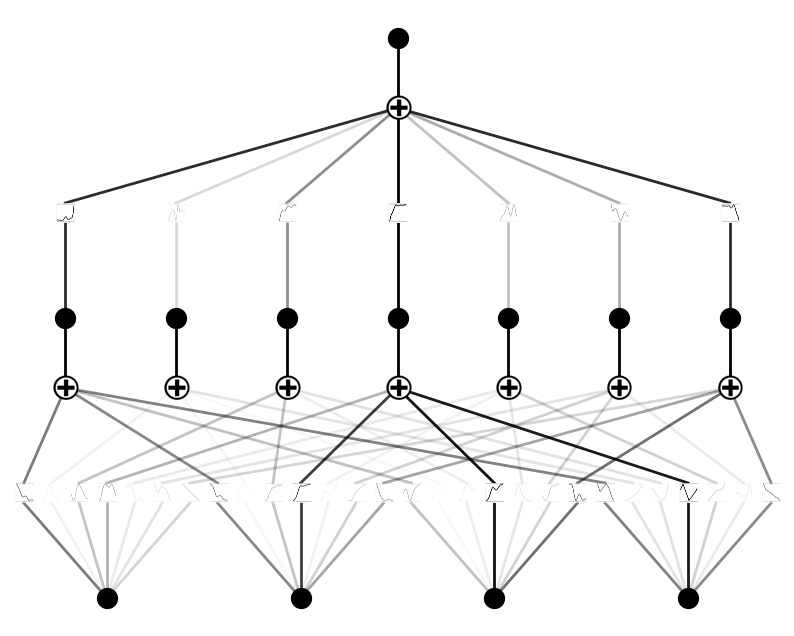

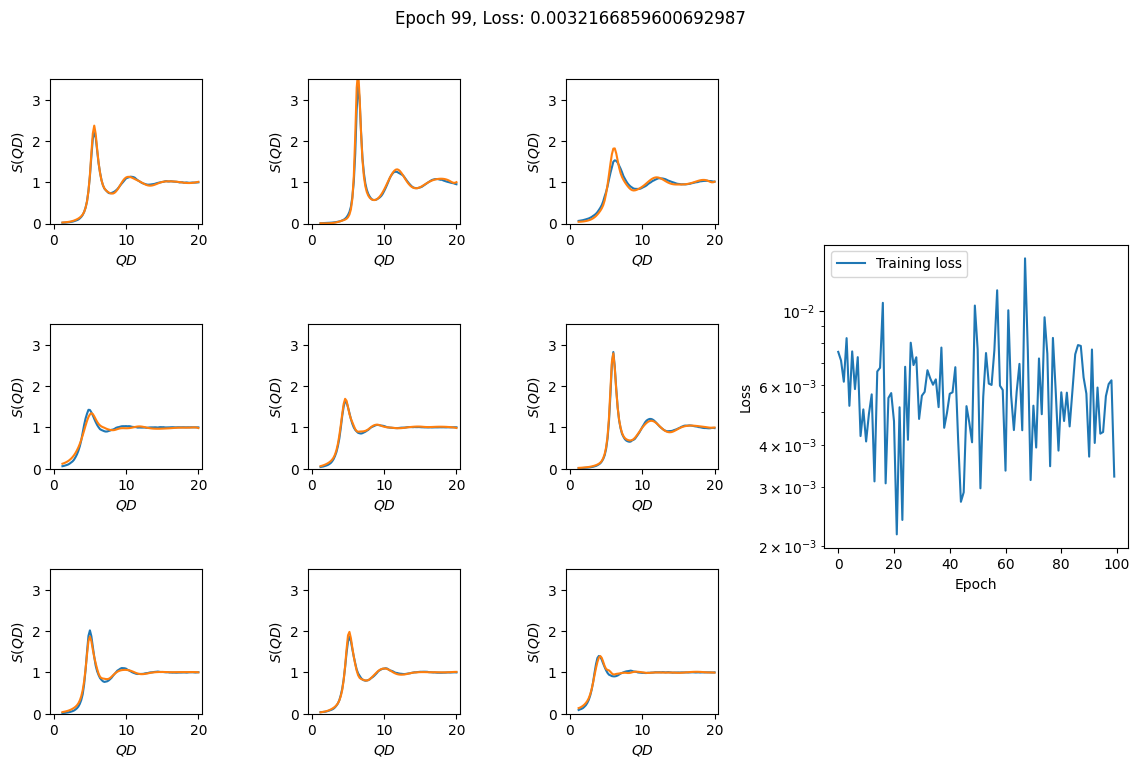

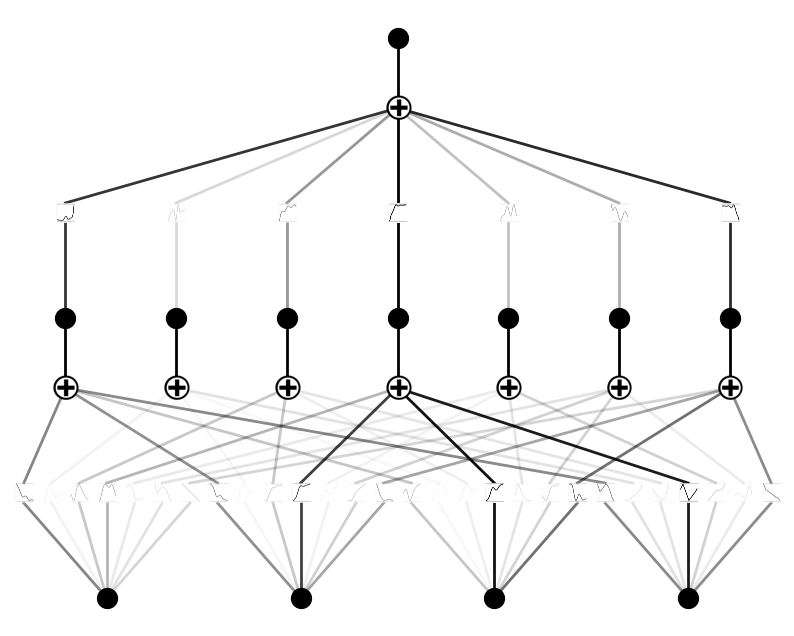

In [28]:
# model_KAN.load_state_dict(torch.load('./saved_model/KAN/model_77_7_grid.pth'))
train_model_KAN(model_KAN, x_train, y_train, epochs=100, batch_size=256, lr=5e-3)

In [29]:
# Use glob to get the filenames
save_path="./figures/KAN/"
filenames = sorted(glob.glob(os.path.join(save_path, '*.png')))

print(filenames)  # Print the filenames

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(os.path.join(save_path, 'training.gif'), images)

['./figures/KAN/epoch_0000.png']


/tmp/ipykernel_596123/913100899.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [30]:
torch.save(model_KAN.state_dict(), './saved_model/KAN/model_77_7_grid.pth')

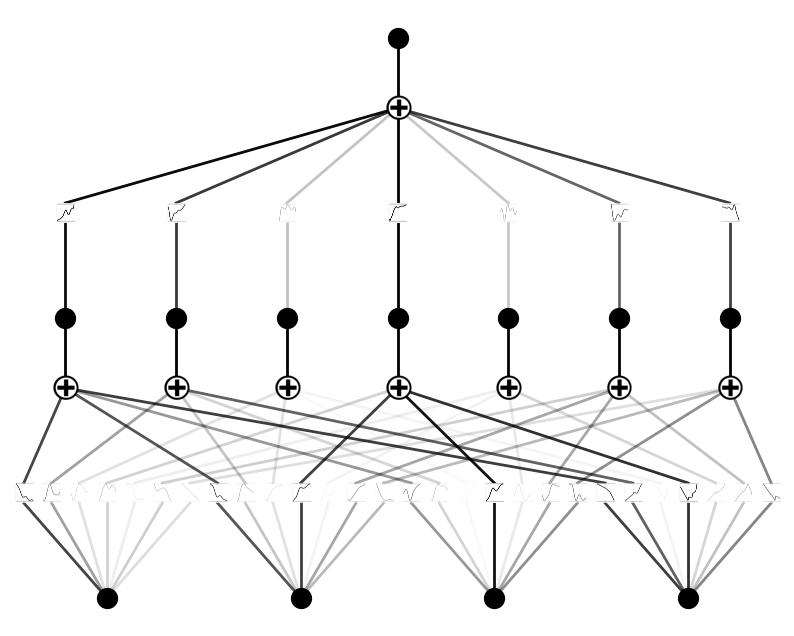

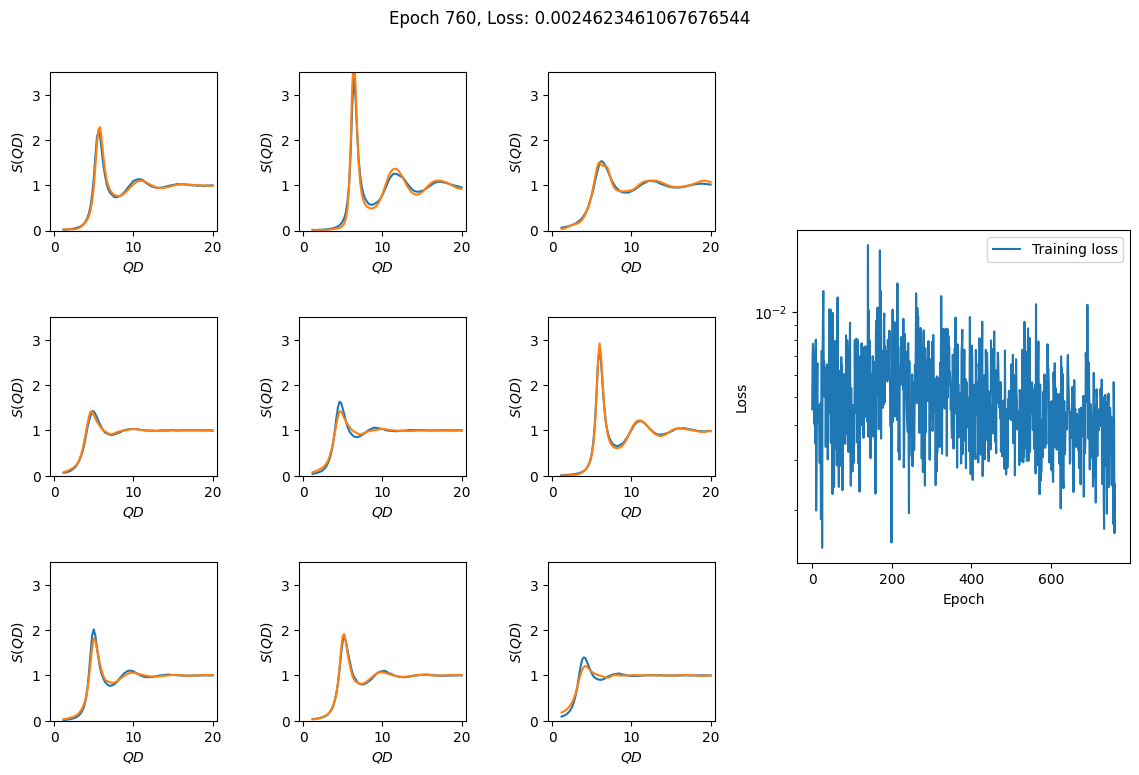

In [31]:
model_KAN.load_state_dict(torch.load('./saved_model/KAN/model_77_7_grid.pth'))
train_model_KAN(model_KAN, x_train, y_train, epochs=1000, batch_size=128, lr=1e-3)

In [18]:
fneme = "./saved_model/KAN/model_77_7_grid_ft.pth"
torch.save(model_KAN.state_dict(), fneme)

In [ ]:
# fname_BR = "./saved_model/KAN/model_77_913_grid.pth"
# torch.save(model_KAN.state_dict(), './saved_model/KAN/model_BR.pth')
# # Open the file in write mode
# with open("./saved_model/KAN/model_BR.txt", 'w') as file:
#     # Write the modified contents back to the file
#     file.writelines(fname_BR)